In this practical assignment you will learn how to work with Bayesian models. This assignment consists of two parts. In the first part you will implement the beta-binomial model discussed in class. In the second part you will learn to work with a Python module called PyMC which implements various probabilistic inference algorithms.

Your code will be evaluated on clarity, conciseness and efficiency. Document your code. The resulting notebook including the required outputs should be converted to pdf and uploaded to Blackboard. Comments can be added in the notebook using markdown cells. Note that for code development you may want to use the PyCharm IDE, which facilitates debugging.

### Assignment 1

Study the lecture slides and implement the binomial model. Write Python functions which compute the prior, likelihood and posterior distribution for θ. The functions are evaluated at m points in the range [0,1]. The prior takes parameters α and β. The likelihood takes parameters k and n. The posterior takes parameters k, n, α and β. Plot the prior, likelihood and posterior for θ given k = 20, n = 40, α = 2, β = 10.

----
Since the posterior is also a beta distribution, I just define two classes one for a beta distribution and one for a binomial distribution.

In [1]:
import numpy as np
from scipy.special import binom, beta
import matplotlib.pyplot as plt
%matplotlib inline  
class Beta():
    """ 
    Representing a beta distrubtion with a fixed alpha and beta
    parameter
    """
    def __init__(self, alpha, beta):
        """ 
        Does initialize a new beta distribution, with fixed alpha 
        and beta parameters
        """
        self.alpha = alpha
        self.beta = beta
    
    def p(self, theta):
        """
        Return the probability density for theta for the current beta
        distribution
        """
        return (1./beta(self.alpha, self.beta)) * \
               np.power(theta, self.alpha -1) * \
               np.power(1. - theta, self.beta - 1)
    
    @staticmethod
    def as_posterior(prior, likelihood):
        """
        Returns a new posterior beta distribution given a beta dist.
        as prior and a binomial dist as likelihood
        """
        return Beta(prior.alpha + likelihood.k,\
                    likelihood.n - likelihood.k + prior.beta)

class Binomial():
    """
    Representing a binomial distribution with fixed k and n parameters
    """
    def __init__(self, k, n):
        """
        Doest initialize a new Binomial dist. with fixed parameters k a
        nd n
        """
        self.k = k
        self.n = n
    
    def p(self, theta):
        """
        Returns the probability density for fixed k and fixed n 
        given theta
        """
        return binom(self.n, self.k) * np.power(theta, self.k) * \
                np.power(1. - theta, self.n - self.k)
    

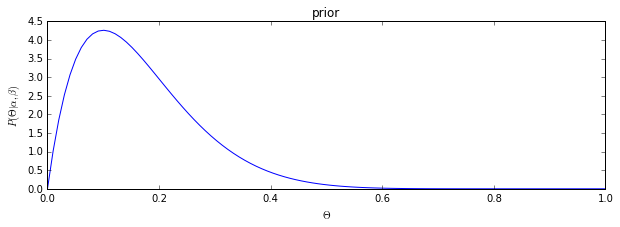

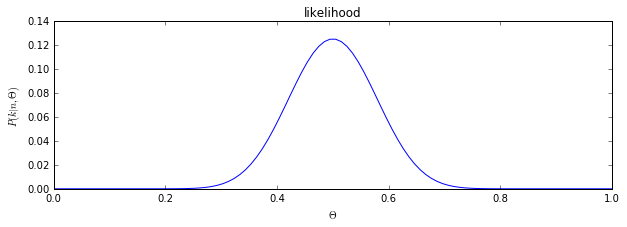

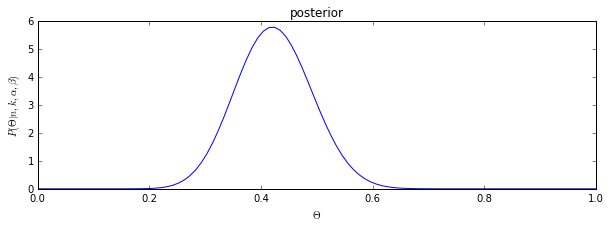

In [2]:
# helper function to plot specific dist.
def plot(dist, title, y_label):
    x = np.linspace(0.,1.,100) # domain
    y = dist.p(x) # p for each x
    plt.figure(figsize=(10,3))
    plt.plot(x, y)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel("$\Theta$")
    plt.show()

# define dists.
# binomial dist with k = 20, n = 20
likelihood = Binomial(20, 40) 
# beta prior with alpha = 2, beta = 10
prior = Beta(2,10) 
# beta posterior of beta and likelihood
posterior = Beta.as_posterior(prior, likelihood) 

# plot dists
plot(prior, 'prior',"$P(\Theta| \\alpha,\\beta)$")
plot(likelihood, 'likelihood', '$P(k|n, \Theta)$' )
plot(posterior, 'posterior', '$P(\Theta |n, k,\\alpha,\\beta)$' )

### Assignment 2

In this assignment you will get acquainted with pyMC. The module documentation can be found here:

https://pymc-devs.github.io/pymc/

We will work through part of the following tutorial:

https://peerj.com/articles/cs-55/

Implement the tutorial <i>A Motivating Example: Linear Regression</I>. At the end of the tutorial provide a summary for all variables rather than only for alpha. This can be done using summary(trace). Make sure you understand what the summary tells you.

-----

### Generating dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize random number generator
np.random.seed(2442)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.linspace(0, 1, size)
X2 = np.linspace(0,.2, size)

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

This code generates a dataset based on the model we want to learn. I picked a different seed from the tutorial to get different results. Which is a gaussian
$$Y \sim N(\mu, \sigma^2) $$
First we calculate the $\mu$ over our domain

In [ ]:
alpha + beta[0]*X1 + beta[1]*X2

`np.random.rand(size)` returns size samples sampled from a normal distribution with mean 0 and variance 1. This thus introduces the variance of our model:

In [4]:
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

### Building the model

In [5]:
from pymc3 import Model, Normal, HalfNormal
basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Applied log-transform to sigma and added transformed sigma_log to model.


The priors of our parameters $\alpha$, $\beta_1$ and $\beta_2$ are normal distributions with mean 0 and sd 10. The prior $\sigma$ is defined as a positive number: 
$$ \sigma \sim | N(0,1) | $$ 
In our model we represent this as a HalfNormal distribution.

Lastly we define our likelihood function as a normal distribution with our mean $\mu$, $\sigma$ and our generated data. We now have a prior for each of our parameters and likelihood function for our observations. We can thus start applying bayes rule to obtain probabilities over our parameters. 

### Point estimation (MAP)

We can use MAP to find the maximum a posteriori value of our model. This comes down to the most likely values of the parameters given our observations and given our priors

In [6]:
from pymc3 import find_MAP
from pprint import PrettyPrinter
map_estimate = find_MAP(model=basic_model)

pp = PrettyPrinter()
pp.pprint(map_estimate)

{'alpha': array(1.1808943778865792),
 'beta': array([ 1.41092719,  0.28218544]),
 'sigma_log': array(-0.06054685928674139)}


The found alpha and sigma values are pretty close to the original values of 1 and 1. (note that the log of sigma is given). However the two beta values are pretty different from the actual values..

### Gradient-based sampling methods (NUTS)

In [7]:
from pymc3 import NUTS, sample,traceplot,summary

with basic_model:

    # obtain starting values via MAP
    start = find_MAP()

    # instantiate sampler
    step = NUTS(scaling=start)

    # draw 2000 posterior samples
    trace = sample(2000, step, start=start)

 [-----------------100%-----------------] 2000 of 2000 complete in 6.1 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123a07b50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x122050110>]], dtype=object)

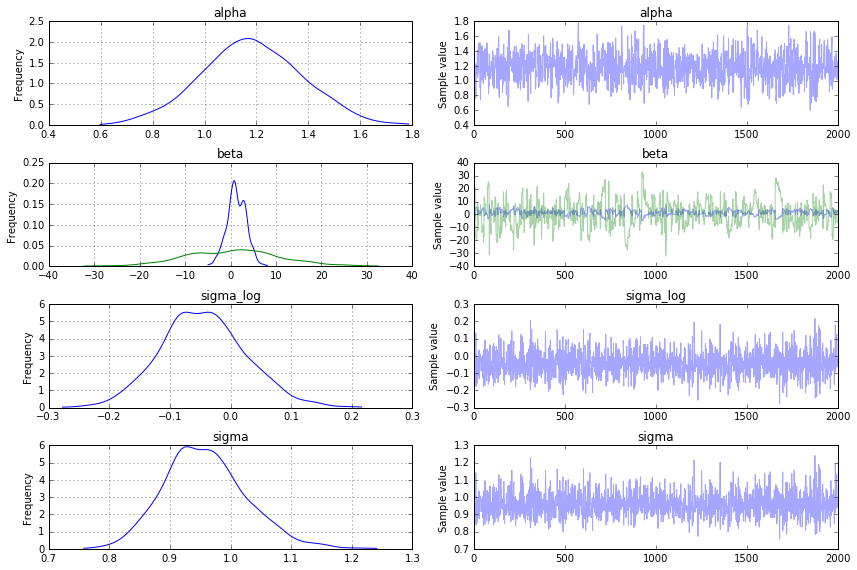

In [8]:
traceplot(trace)

In [9]:
summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.181            0.192            0.006            [0.824, 1.574]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.802          1.053          1.178          1.310          1.557


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.351            2.073            0.133            [-2.515, 5.504]
  0.604            10.204           0.657            [-19.676, 19.361]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.879         0.023          1.210          2.865          5.304
  -18.739        -6.819         0.82

We see that the posterior of the alpha variable is pretty accurate, the mean is a bit to high(1.18 vs a real value of 1.0). But the sd of .192 represents a uncertainty about this value that makes sense. Next we see that the beta's values are harder to get right. This is represented in the relative high standard deviations of 2. and 10.2. The sigma posterior distribution is very certain and very accurate mean:.959 and sd .068. All these values explain our results at the MAP function, where we saw that alpha was close but a bit off. $\beta_1$ was quit a bit off and $\beta_2$ was very wrong. $\sigma$ however was very accurate. Clearly having a distribution over your final parameters has advantages over the most likely points.